# MNIST Basics

In [78]:
from fastai2.vision.all import *

In [79]:
path = untar_data(URLs.MNIST_SAMPLE)

In [80]:
path.ls()

(#3) [Path('C:/Users/Archel/.fastai/data/mnist_sample/labels.csv'),Path('C:/Users/Archel/.fastai/data/mnist_sample/train'),Path('C:/Users/Archel/.fastai/data/mnist_sample/valid')]

In [81]:
(path/'train').ls()

(#2) [Path('C:/Users/Archel/.fastai/data/mnist_sample/train/3'),Path('C:/Users/Archel/.fastai/data/mnist_sample/train/7')]

In [82]:
threes = (path/'train'/'3').ls()
sevens = (path/'train'/'7').ls()

In [83]:
im3_path = threes[0]
im3 = Image.open(im3_path)
im3

In [84]:
array(im3)[4:10, 4:10]

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=uint8)

In [85]:
tensor(im3)[4:10, 4:10]

tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], dtype=torch.uint8)

In [86]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15, 4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,42,118,219,166,118,118,6,0,0,0,0
1,0,0,0,0,0,0,103,242,254,254,254,254,254,66,0,0,0,0
2,0,0,0,0,0,0,18,232,254,254,254,254,254,238,70,0,0,0
3,0,0,0,0,0,0,0,104,244,254,224,254,254,254,141,0,0,0
4,0,0,0,0,0,0,0,0,207,254,210,254,254,254,34,0,0,0
5,0,0,0,0,0,0,0,0,84,206,254,254,254,254,41,0,0,0
6,0,0,0,0,0,0,0,0,0,24,209,254,254,254,171,0,0,0
7,0,0,0,0,0,0,0,0,91,137,253,254,254,254,112,0,0,0
8,0,0,0,0,0,0,40,214,250,254,254,254,254,254,34,0,0,0
9,0,0,0,0,0,0,81,247,254,254,254,254,254,254,146,0,0,0


## Pixel Similarity

In [87]:
three_tensors = [tensor(Image.open(f)) for f in threes]
seven_tensors = [tensor(Image.open(f)) for f in sevens]
len(three_tensors), len(seven_tensors)

(6131, 6265)

<AxesSubplot:>

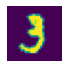

In [88]:
show_image(three_tensors[0])

In [89]:
stacked_threes = torch.stack(three_tensors).float()/255.
stacked_sevens = torch.stack(seven_tensors).float()/255.

In [90]:
stacked_threes.shape, stacked_sevens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

In [91]:
stacked_threes.ndim, stacked_threes.ndim == len(stacked_threes.shape)

(3, True)

<AxesSubplot:>

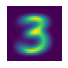

In [92]:
mean_3 = stacked_threes.mean(0)
show_image(mean_3)

<AxesSubplot:>

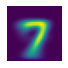

In [93]:
mean_7 = stacked_sevens.mean(0)
show_image(mean_7)

<AxesSubplot:>

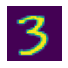

In [94]:
a_3 = stacked_threes[1]
show_image(a_3)

In [95]:
# MAE (Mean Absolute Error)
dist_3_abs = (a_3 - mean_3).abs().mean()
# RMSE (Root Mean Squared Error)
dist_3_sqr = ((a_3 - mean_3) ** 2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [96]:
# MAE (Mean Absolute Error)
dist_7_abs = (a_3 - mean_7).abs().mean()
# RMSE (Root Mean Squared Error)
dist_7_sqr = ((a_3 - mean_7) ** 2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [97]:
# or use F.l1_loss
F.l1_loss(a_3, mean_3), F.l1_loss(a_3, mean_7)

(tensor(0.1114), tensor(0.1586))

In [98]:
# validation set
valid_3_t = torch.stack([tensor(Image.open(f)) for f in (path/'valid'/'3').ls()])
valid_3_t = valid_3_t / 255.
valid_7_t = torch.stack([tensor(Image.open(f)) for f in (path/'valid'/'7').ls()])
valid_7_t = valid_7_t / 255.
valid_3_t.shape, valid_7_t.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [99]:
def mnist_distance(a, b):
#     return F.l1_loss(a, b)
    return (a-b).abs().mean((-1,-2))

In [100]:
mnist_distance(a_3, mean_3)

tensor(0.1114)

In [101]:
valid_3_dist = mnist_distance(valid_3_t, mean_3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1280, 0.1623, 0.1242,  ..., 0.1508, 0.1263, 0.1260]),
 torch.Size([1010]))

In [102]:
def is_3(x):
    return mnist_distance(x, mean_3) < mnist_distance(x, mean_7)

In [103]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [104]:
is_3(valid_3_t)

tensor([ True,  True,  True,  ..., False,  True,  True])

In [105]:
accuracy_3 = is_3(valid_3_t).float().mean()
accuracy_7 = 1 - is_3(valid_7_t).float().mean()
accuracy_3, accuracy_7, (accuracy_3+accuracy_7)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## Gradient Descent

In [106]:
# prepare training data
x_train = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
y_train = torch.Tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
x_train.shape, y_train.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [107]:
# convert to a dataset (tuple)
dset = list(zip(x_train, y_train))
x, y = dset[0]
x.shape, y.shape

(torch.Size([784]), torch.Size([1]))

In [108]:
# do the same for validation set
x_valid = torch.cat([valid_3_t, valid_7_t]).view(-1, 28*28)
y_valid = torch.Tensor([1]*len(valid_3_t) + [0]*len(valid_7_t)).unsqueeze(1)
dset_valid = list(zip(x_valid, y_valid))

In [109]:
# init params
def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()

In [110]:
weights = init_params(28*28,1)
bias = init_params(1)

In [111]:
# linear function
def linear(x):
    return x@weights + bias

In [112]:
preds = linear(x_train)
preds

tensor([-18.5948, -13.0183, -21.5130,  ...,   3.3052,  -3.0296,  -1.3512],
       grad_fn=<AddBackward0>)

In [113]:
# sigmoid function
def sigmoid(x):
    return 1 / (1+torch.exp(-x))

In [114]:
# loss function
def mnist_loss(preds, targets):
    predictions = preds.sigmoid()
    
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [115]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [116]:
weights = init_params(28*28,1)
bias = init_params(1)

In [117]:
dl = DataLoader(dset, bs=256)
dl_valid = DataLoader(dset_valid, bs=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [118]:
batch = x_train[:4]
batch.shape

torch.Size([4, 784])

In [119]:
preds = linear(batch)
preds

tensor([ -0.9048, -12.0145,  -3.3055,  -1.2798], grad_fn=<AddBackward0>)

In [120]:
loss = mnist_loss(preds, y_train[:4])
loss

tensor(0.8647, grad_fn=<MeanBackward0>)

In [121]:
calc_grad(batch, y_train[:4], linear)
weights.grad.mean(), bias.grad

(tensor(-0.0160), tensor([-0.1024]))

In [122]:
# don't forget to zero out grads
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

In [123]:
# now we get the same gradients
calc_grad(batch, y_train[:4], linear)
weights.grad.mean(), bias.grad

(tensor(-0.0160), tensor([-0.1024]))

In [124]:
# our training loop
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [125]:
# accuracy
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds > 0.5) == yb
    
    return correct.float().mean()

In [126]:
batch_accuracy(linear(batch), y_train[:4])

tensor(0.)

In [127]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in dset_valid]
    return round(torch.stack(accs).mean().item(), 4)

In [128]:
validate_epoch(linear)

0.553

In [129]:
# single epoch
lr = 1.
params = weights,bias
train_epoch(linear, lr, params)
validate_epoch(linear)

0.6752

In [130]:
# train for longer epochs
for _ in range(20):
    train_epoch(linear, lr, params)
    print(validate_epoch(linear), end=' ')

0.841 0.9053 0.9298 0.9411 0.9514 0.9553 0.9603 0.9617 0.9627 0.9647 0.9661 0.9686 0.9686 0.9696 0.9696 0.9701 0.9711 0.972 0.972 0.972 

## With Optimizer

In [131]:
linear_model = nn.Linear(28*28,1)

In [132]:
w, b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [133]:
class BasicOptim:
    def __init__(self, params, lr): self.params, self.lr = list(params), lr
    
    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr
            
    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None
    

In [134]:
opt = BasicOptim(linear_model.parameters(), lr)

In [135]:
def new_train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [136]:
validate_epoch(linear_model)

0.4298

In [137]:
def train_model(model, epochs):
    for i in range(epochs):
        new_train_epoch(model)
        print(validate_epoch(model), end=' ')

In [138]:
train_model(linear_model, 20)

0.4956 0.896 0.8057 0.9058 0.9303 0.945 0.9544 0.9617 0.9647 0.9671 0.9681 0.9711 0.9725 0.975 0.976 0.976 0.9774 0.9779 0.9779 0.9789 

In [139]:
# with built-in PyTorch optimizer
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4956 0.7949 0.8528 0.9171 0.9347 0.95 0.9563 0.9627 0.9657 0.9676 0.9701 0.9715 0.9735 0.975 0.976 0.976 0.9774 0.9779 0.9779 0.9784 

In [140]:
# with learn.fit
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
dls = DataLoaders(dl, dl_valid)
learn = Learner(dls, linear_model, loss_func=mnist_loss, opt_func=SGD, metrics=batch_accuracy)

In [141]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637026,0.502164,0.495584,00:00
1,0.329513,0.290074,0.714917,00:00
2,0.128342,0.156579,0.860648,00:00
3,0.060791,0.098456,0.918057,00:00
4,0.035520,0.073554,0.935231,00:00
5,0.025386,0.059633,0.951914,00:00
6,0.021059,0.050876,0.956330,00:00
7,0.019019,0.045000,0.963199,00:00
8,0.017903,0.040825,0.966143,00:00
9,0.017182,0.037714,0.967615,00:00


## Adding non-linearity

In [142]:
def simple_net(x):
    res = x@w1 + b1
    res = res.max(tensor(0.0))
    res = x@w2 + b2
    
    return res

In [143]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

In [144]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [145]:
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

In [146]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.305915,0.423671,0.504416,00:00
1,0.146364,0.227520,0.809127,00:00
2,0.081093,0.114025,0.916094,00:00
3,0.053349,0.076972,0.942591,00:00
4,0.040487,0.060180,0.956330,00:00
5,0.033918,0.050778,0.965162,00:00
6,0.030145,0.044860,0.965653,00:00
7,0.027695,0.040811,0.966143,00:00
8,0.025931,0.037859,0.968106,00:00
9,0.024563,0.035601,0.971541,00:00


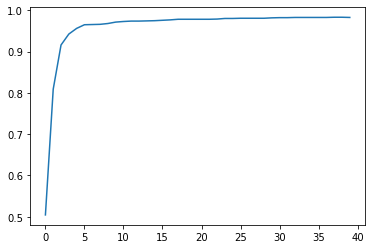

In [147]:
plt.plot(L(learn.recorder.values).itemgot(2))

In [149]:
# last value, 2nd column (batch accuracy)
learn.recorder.values[-1][2]

0.982826292514801